# Predicting Stock Prices using Long Short-Term Memory (LSTM)

In this notebook, we will try to predict Tesla stock prices using LSTM models. LSTMs are a special kind of Recurrent Neural Network (RNN) introduced by Hochreiter and Schmidhuber (1997). They are widely used to learn long term dependencies.

First, we upload and preprocess data. Then, we implement a Vanilla LSTM model to predict one day into the future. Finally, we study a multi-Step LSTM to predict several days into the future.

Very useful links are provided at the end of the notebook. Those links will help you go through simple data processing and LSTMs.

### Summary
* [1. Data Preprocessing](#chapter1)
    * [a. Upload and plot data](#section_1_1)
    * [b. Checking stationarity](#Section_1_2)
    * [c. Making our time series stationary](#Section_1_3)
* [2. LSTM](#chapter2)
    * [a. Preprocessing again for LSTM](#section_2_1)
    * [b. Split Data (train set and test set)](#section_2_2)
    * [c. Implementing the model](#section_2_3)
    * [d. Training and evaluating the model](#section_2_4)
    * [e. Predictions](#section_2_5)
* [3. Multi-Step LSTM](#chapter2)
    * [a. Preprocessing](#section_3_1)
    * [b. Splitting Data](#section_3_2)
    * [c. Implementing the model](#section_3_3)
    * [d. Training and evaluating the model](#section_3_4)
    * [e. Predictions](#section_3_5)
* [Useful Links](#links)

    

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 1. Data preprocessing <a class="anchor" id="chapter1"></a>
### a. Upload and plot data <a class="anchor" id="section_1_1"></a>

In [2]:
# Tesla stock: TSLA
company = 'Tesla' 
stock_data = pd.read_csv('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/tsla.us.txt', parse_dates=['Date'], sep=',', index_col='Date')

In [3]:
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.00,17.00,17.00,17.00,0,0
2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2010-06-30,25.79,30.42,23.30,23.83,17194394,0
2010-07-01,25.00,25.92,20.27,21.96,8229863,0
2010-07-02,23.00,23.10,18.71,19.20,5141807,0
...,...,...,...,...,...,...
2017-11-06,307.00,307.50,299.01,302.78,6482486,0
2017-11-07,301.02,306.50,300.03,306.05,5286320,0
2017-11-08,305.50,306.89,301.30,304.31,4725510,0


Text(0.5, 1.0, 'Tesla stock closing price')

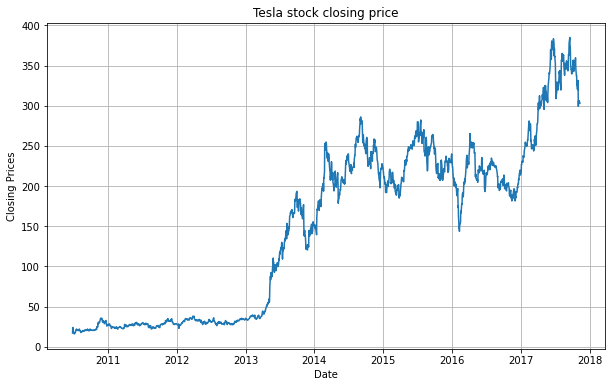

In [4]:
# Plot closing prices
df_close = stock_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Tesla stock closing price')

### b. Checking stationarity <a class="anchor" id="section_1_2"></a>
A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time. The reason why we verify time series stationarity is because we cannot build a time series model if the time series is not stationary. Let's verify that the time series is stationary.

To do so, we will use the rolling statistics plots along with augmented Dickey-Fuller test results.

The Dickey-Fuller tests the null hypothesis that a unit root is present in a time series model. The alternative hypothesis is the stationarity of the model.


Note: 
The intuition behind the test is as follows. If the series y is stationary (or trend-stationary), then it has a tendency to return to a constant (or deterministically trending) mean. Therefore, large values will tend to be followed by smaller values (negative changes), and small values by larger values (positive changes). Accordingly, the level of the series will be a significant predictor of next period's change, and will have a negative coefficient. If, on the other hand, the series is integrated, then positive changes and negative changes will occur with probabilities that do not depend on the current level of the series; in a random walk, where you are now does not affect which way you will go next. (source: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)

In [5]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

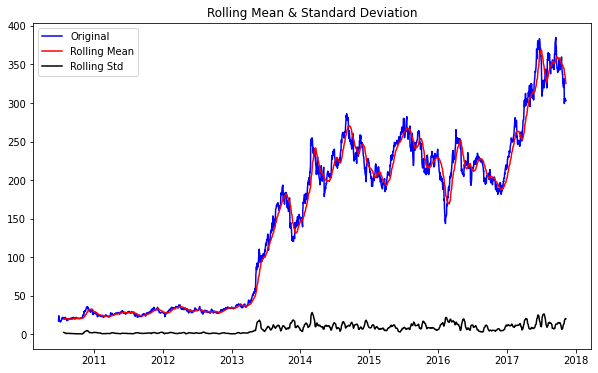

Results of Dickey-Fuller Test:
Test Statistic                   -0.842866
p-value                           0.806205
#Lags Used                        1.000000
Number of Observations Used    1856.000000
Critical Value (1%)              -3.433878
Critical Value (5%)              -2.863099
Critical Value (10%)             -2.567600
dtype: float64


In [6]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

First, on the above graph, we can see that the rolling mean is increasing. Thus, the time series is not stationary.

The p-value is greater than the $5\%$ critical value, so the null hypothesis cannot be rejected.

Regarding the test statistic used in the augmented Dickey-Tuller statistic, it is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

Here, -0.84 is greater than the -2.86 critical value at the $95\%$ confidence bound. Therefore, we can confirm that the null hypotheis cannot be rejected.

Let's apply some transformation to make our time series stationary.

### c. Making our time series stationary <a class="anchor" id="section_1_3"></a>


There are three major time series patterns: trend, seasonality, and cycles. Trend and cycles are usually combined into a single component, leaving us with a trend-cycle component, a seasonal component, and a remainder component (containing the rest of the time series).

To make our time series stationary, the principle is to estimate trend and seasonality, and to remove those from the time series. Then, we can apply the forecasting technique (i.e here LSTM), the final step being to convert the forcasted values into the original scale by adding the estimated trend and seasonality.

<Figure size 432x288 with 0 Axes>

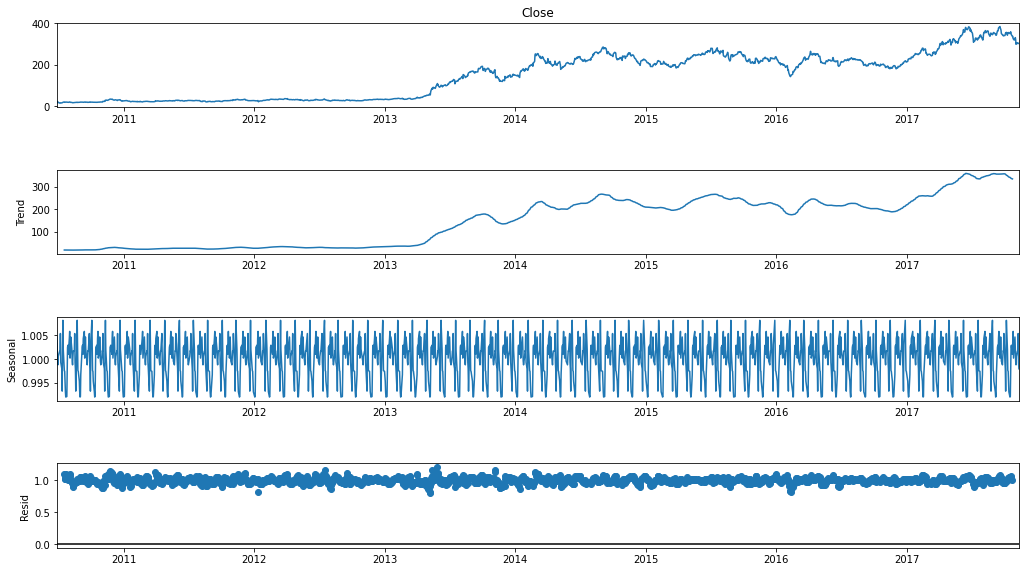

In [7]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a 
# month
# The result below is just to have a first visualization of trend and
# seasonality. Here we take a monthly average but to forecast a stock 
# price, it is more difficult than that to choose the right number of
# days to average on
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by estimating and eliminating trends. As the time series is constantly increasing, we apply a log transform, and a square root transform to flatten it.

Text(0.5, 1.0, 'Transformed data')

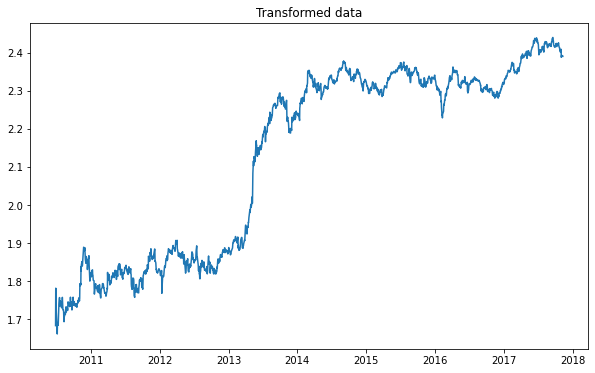

In [8]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

Let's know use one classical method to deal with trend and seasonality: differenciating.
We take the difference of the observation at a particular instant with that at the previous instant.

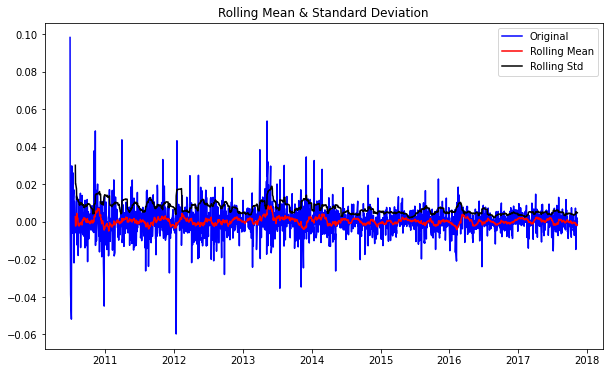

Results of Dickey-Fuller Test:
Test Statistic                  -32.550253
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1855.000000
Critical Value (1%)              -3.433880
Critical Value (5%)              -2.863099
Critical Value (10%)             -2.567600
dtype: float64


In [9]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

We obtain significally better results:

The test statistic is a lot lower than the critical value at 1%. Therefore, we can say with more than 99% confidence that this is a stationary series. Moreover, as the p-value is inferior to the 5% threshold, the null hypothesis is rejected, meaning that the Dickey-Fuller test is verified. Thus, the time series is stationary.

## 2. LSTM <a class="anchor" id="chapter2"></a>

We will implement the Long Short-Term Memory (LSTM) cells to predict future values of the stock price.

LSTMs are a special kind of Recurrent Neural Network (RNN) introduced by Hochreiter and Schmidhuber (1997). They are widely use to learn long term dependencies.

### a. Preprocessing again for LSTM <a class="anchor" id="section_2_1"></a>
Data need to be preprocessed in order to be passed to an LSTM model. In this section we will predict one day into the future. For the Multi-Step LSTM model, please take a look at part 3. 

Example:

Input: $[1,2,3,4,5,6,7,8,9,10]$

Input preprocessed: 
     
$X: [1,2,3,4], [2,3,4,5], [3,4,5,6], ...$

$y: [5,6,7,...]$
                        
We also need to reshape X as the model expects as input a training data of shape $[samples, timesteps, features]$.

Here, we are working with a univariate series, so the number of feature is one.

Finally, we choose the number of days on which to base our predictions to be 60 days.

In [10]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [11]:
# choose the number of days on which to base our predictions 
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

### b. Split Data (train set and test set) <a class="anchor" id="section_2_2"></a>
We split the set between a training set and a test set. For the test set, we take the last year (365 days) of the dataset.

Then, we visualize both set with the original data.

In [12]:
#Split the data set between the training set and the test set
test_days = 365 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

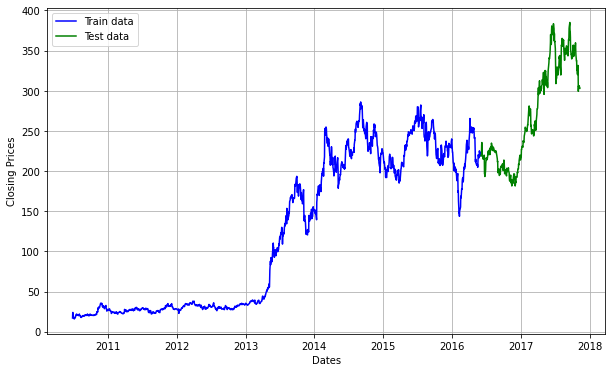

In [13]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

### c. Implementing the model <a class="anchor" id="section_2_3"></a>

We implement the most simple LSTM model, the "Vanilla LSTM". This model consists in a single hidden layer of LSTM unit, and one output layer used to make predictions.

In [14]:
def vanilla_LSTM():
    model = Sequential()    
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [15]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


### d. Training and evaluating the model <a class="anchor" id="section_1_4"></a>

In [16]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

Epoch 1/15
45/45 [==============================] - 2s 20ms/step - loss: 9.6160e-05 - mean_absolute_error: 0.0072
Epoch 2/15
45/45 [==============================] - 1s 20ms/step - loss: 6.4326e-05 - mean_absolute_error: 0.0055
Epoch 3/15
45/45 [==============================] - 1s 19ms/step - loss: 7.2244e-05 - mean_absolute_error: 0.0059
Epoch 4/15
45/45 [==============================] - 1s 20ms/step - loss: 7.5874e-05 - mean_absolute_error: 0.0062
Epoch 5/15
45/45 [==============================] - 1s 21ms/step - loss: 6.3509e-05 - mean_absolute_error: 0.0056
Epoch 6/15
45/45 [==============================] - 1s 19ms/step - loss: 7.2361e-05 - mean_absolute_error: 0.0056
Epoch 7/15
45/45 [==============================] - 1s 20ms/step - loss: 6.9146e-05 - mean_absolute_error: 0.0059
Epoch 8/15
45/45 [==============================] - 1s 20ms/step - loss: 7.8709e-05 - mean_absolute_error: 0.0060
Epoch 9/15
45/45 [==============================] - 1s 20ms/step - loss: 6.5340e-05 - me

In [17]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 0s 7ms/step - loss: 2.1695e-05 - mean_absolute_error: 0.0034
Test MSE: 2.169531762774568e-05
Test MAE: 0.003427055198699236


Both the Mean Square Error (MSE) and the Mean Absolute Error (MAE) are very loss. Thus our model generalize well.

### e. Predictions <a class="anchor" id="section_1_5"></a>

Let's predict stock prices on the test set.

After calling model.predict(), we need to apply the part 1.d inverse transformations to the predicted data to be able to compare our predictions with the original data.


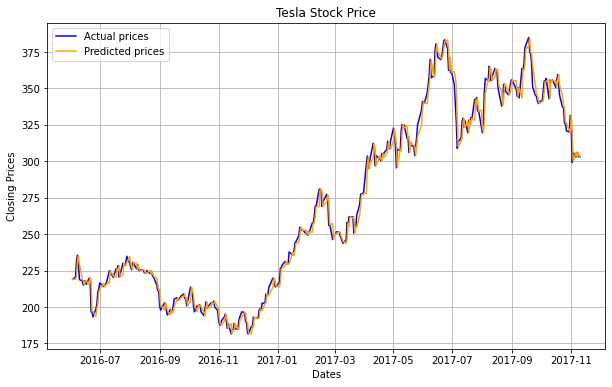

In [18]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:] 

# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

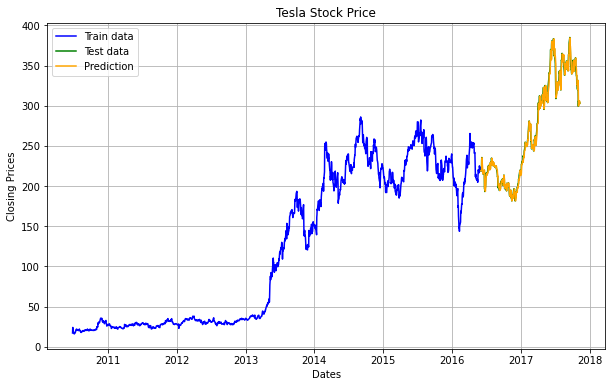

In [19]:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

Although our model have difficulties predicting sudden variations. Predictions are very close to reality.

## 3. Multi-Step LSTM <a class="anchor" id="chapter3"></a>

LSTM model can also be used to predict several step into the future.

Let's modify our code above to enable multi-step predictions.

### a. Preprocessing <a class="anchor" id="section_3_1"></a>

As for the one step LSTM data need to be preprocessed in order to be passed to an Multi-steps LSTM model. In this section we will predict certain number of days into the future.

Example: If we want to predict 3 days into the future

Input: $[1,2,3,4,5,6,7,8,9,10]$

Input preprocessed: 
     
$X: [1,2,3,4], [2,3,4,5], [3,4,5,6], ...$

$y: [5,6,7], [6,7,8], [7,8,9], ...$

Similarly to part 2.a, we reshape X to match what the model expects as inputs ($[samples, timesteps, features]$), we deal with a univariate series so the number of feature is one, and we choose the number of days on which to base our predictions to be 60 days.
                 

In [20]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    return X, y

In [21]:
# Number of days into the future we want to predict
n_steps_out = 10

# choose the number of days on which to base our predictions 
nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)


### b. Splitting Data <a class="anchor" id="section_3_2"></a>

In [22]:
#Split the data set between the training set and the test set
test_days = 365 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

### c. Implementing the model <a class="anchor" id="section_3_3"></a>

In [23]:
def vanilla_multistep_LSTM():
    model = Sequential()    
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [24]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


### d. Training and evaluating the model <a class="anchor" id="section_3_4"></a>

In [25]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

Epoch 1/15
45/45 [==============================] - 2s 21ms/step - loss: 7.2136e-05 - mean_absolute_error: 0.0059
Epoch 2/15
45/45 [==============================] - 1s 21ms/step - loss: 7.3553e-05 - mean_absolute_error: 0.0058
Epoch 3/15
45/45 [==============================] - 1s 24ms/step - loss: 6.9782e-05 - mean_absolute_error: 0.0057
Epoch 4/15
45/45 [==============================] - 1s 20ms/step - loss: 6.8722e-05 - mean_absolute_error: 0.0057
Epoch 5/15
45/45 [==============================] - 1s 20ms/step - loss: 7.1118e-05 - mean_absolute_error: 0.0058
Epoch 6/15
45/45 [==============================] - 1s 20ms/step - loss: 7.2332e-05 - mean_absolute_error: 0.0058
Epoch 7/15
45/45 [==============================] - 1s 21ms/step - loss: 7.0671e-05 - mean_absolute_error: 0.0058
Epoch 8/15
45/45 [==============================] - 1s 20ms/step - loss: 7.1113e-05 - mean_absolute_error: 0.0058
Epoch 9/15
45/45 [==============================] - 1s 20ms/step - loss: 7.1829e-05 - me

In [26]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 0s 6ms/step - loss: 2.1870e-05 - mean_absolute_error: 0.0035
Test MSE: 2.1869571355637163e-05
Test MAE: 0.003475214121863246


Again the MSE and the MAE are quite low. Thus, our model generalize well.

### e. Predictions <a class="anchor" id="section_3_5"></a>


Now, let's first plot n_steps_out days prediction from one time stamp.
Below we arbitraly choose the 1st day of the test set.

Hence, we are going to plot predictions made on the 1st day for all the 10 days after this day.

Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

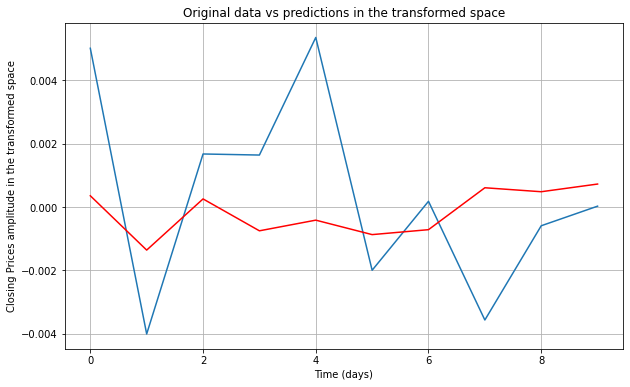

In [27]:
# Prediction
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

Let's now scale back predictions to the the original scale by taking inverse transformations from 3.a.

The first, to convert predictions from the differencing space to the log space, we add predictions consecutively to the base number which is the last value used to make the predictions of interest.

In [28]:
# Apply inverse transformations from 3.a

# Add the differenciation term
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2016-06-03    2.322767
2016-06-06    2.321409
2016-06-07    2.321668
2016-06-08    2.320919
2016-06-09    2.320506
2016-06-10    2.319638
2016-06-13    2.318925
2016-06-14    2.319536
2016-06-15    2.320021
2016-06-16    2.320750
dtype: float64


Then we take the square and the exponent to go to the original space.

In [29]:
# Take the square, and the exponent
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2016-06-03    220.356443
2016-06-06    218.971115
2016-06-07    219.234084
2016-06-08    218.473190
2016-06-09    218.055597
2016-06-10    217.178190
2016-06-13    216.461105
2016-06-14    217.075498
2016-06-15    217.565212
2016-06-16    218.301944
dtype: float64


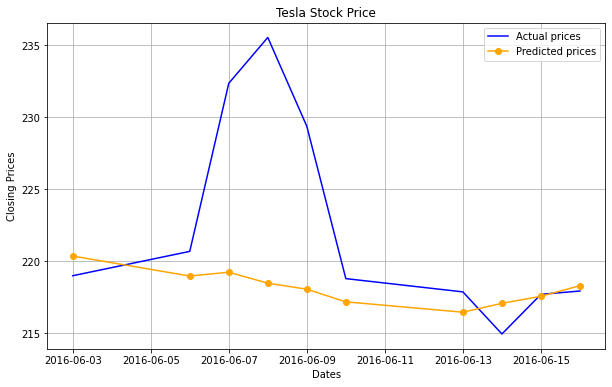

In [30]:
# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

## Useful Links <a class="anchor" id="links"></a>

Examples of LSTM models in Python:

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 


Useful tutorial for timeseries forecasting: 

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
 

Open source “Gluon-TS”. You can use DeepAR model for forecasting if you want an LSTM solution: 

https://github.com/awslabs/gluon-ts 
 

Book that explains forecasting principles:

https://otexts.com/fpp2/ 